In [28]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.callbacks import *
from fastai.callback import *
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from pathlib import Path

In [2]:
image_dir = Path('/home/dsw/data/kaggle/mole/')
model_dir = '.'

# Read in the data

In [3]:
images = get_image_files(image_dir, check_ext='jpg', recurse=True)
images[500:505]

[PosixPath('/home/dsw/data/kaggle/mole/HAM10000_images_part_2/ISIC_0029660.jpg'),
 PosixPath('/home/dsw/data/kaggle/mole/HAM10000_images_part_2/ISIC_0031935.jpg'),
 PosixPath('/home/dsw/data/kaggle/mole/HAM10000_images_part_2/ISIC_0030940.jpg'),
 PosixPath('/home/dsw/data/kaggle/mole/HAM10000_images_part_2/ISIC_0032883.jpg'),
 PosixPath('/home/dsw/data/kaggle/mole/HAM10000_images_part_2/ISIC_0031979.jpg')]

In [4]:
x = '/home/dsw/data/kaggle/mole/HAM10000_images_part_2/ISIC_0029660.jpg'

In [5]:
image_rel = ['/'.join(str(x).split('/')[-2:]) for x in images]
image_rel[:5]

['HAM10000_images_part_2/ISIC_0031185.jpg',
 'HAM10000_images_part_2/ISIC_0033579.jpg',
 'HAM10000_images_part_2/ISIC_0034120.jpg',
 'HAM10000_images_part_2/ISIC_0029875.jpg',
 'HAM10000_images_part_2/ISIC_0030941.jpg']

In [6]:
image_key = [x.stem for x in images]
image_dict = dict(zip(image_key,zip(images, image_rel)))
image_df = pd.DataFrame.from_dict(image_dict, orient='index', columns=['f_path', 'dirname'])
image_df.head()

f_path  \
ISIC_0031185  /home/dsw/data/kaggle/mole/HAM10000_images_par...   
ISIC_0033579  /home/dsw/data/kaggle/mole/HAM10000_images_par...   
ISIC_0034120  /home/dsw/data/kaggle/mole/HAM10000_images_par...   
ISIC_0029875  /home/dsw/data/kaggle/mole/HAM10000_images_par...   
ISIC_0030941  /home/dsw/data/kaggle/mole/HAM10000_images_par...   

                                              dirname  
ISIC_0031185  HAM10000_images_part_2/ISIC_0031185.jpg  
ISIC_0033579  HAM10000_images_part_2/ISIC_0033579.jpg  
ISIC_0034120  HAM10000_images_part_2/ISIC_0034120.jpg  
ISIC_0029875  HAM10000_images_part_2/ISIC_0029875.jpg  
ISIC_0030941  HAM10000_images_part_2/ISIC_0030941.jpg

In [7]:
mole_df = pd.read_csv(image_dir/'HAM10000_metadata.csv')
mole_df.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [8]:
model_df = pd.merge(mole_df, image_df, left_on='image_id', right_index=True, sort=False, validate='1:1')

In [9]:
pd.options.display.max_colwidth = 100
model_df.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                                               f_path  \
0  /home/dsw/data/kaggle/mole/HAM10000_images_part_1/ISIC_0027419.jpg   
1  /home/dsw/data/kaggle/mole/HAM10000_images_part_1/ISIC_0025030.jpg   
2  /home/dsw/data/kaggle/mole/HAM10000_images_part_1/ISIC_0026769.jpg   
3  /home/dsw/data/kaggle/mole/HAM10000_images_part_1/ISIC_0025661.jpg   
4  /home/dsw/data/kaggle/mole/HAM10000_images_part_2/ISIC_0031633.jpg   

                                   dirname  
0  HAM10000_images_part_1/ISIC_0027419.jpg  
1  HAM10000_images_part_1/ISIC_0025030.jpg  
2  HAM10000_images_part_1/ISIC_0026769.jpg  
3  HAM10000_images_part_1/ISIC_0025661.jpg  
4  HAM10000_images_part_2/ISIC_0031633.jpg

In [10]:
bs = 128
transforms = get_transforms(flip_vert=True)

In [11]:
data = ImageDataBunch.from_df(path=image_dir, df=model_df, seed=9878, fn_col='dirname', label_col='dx')

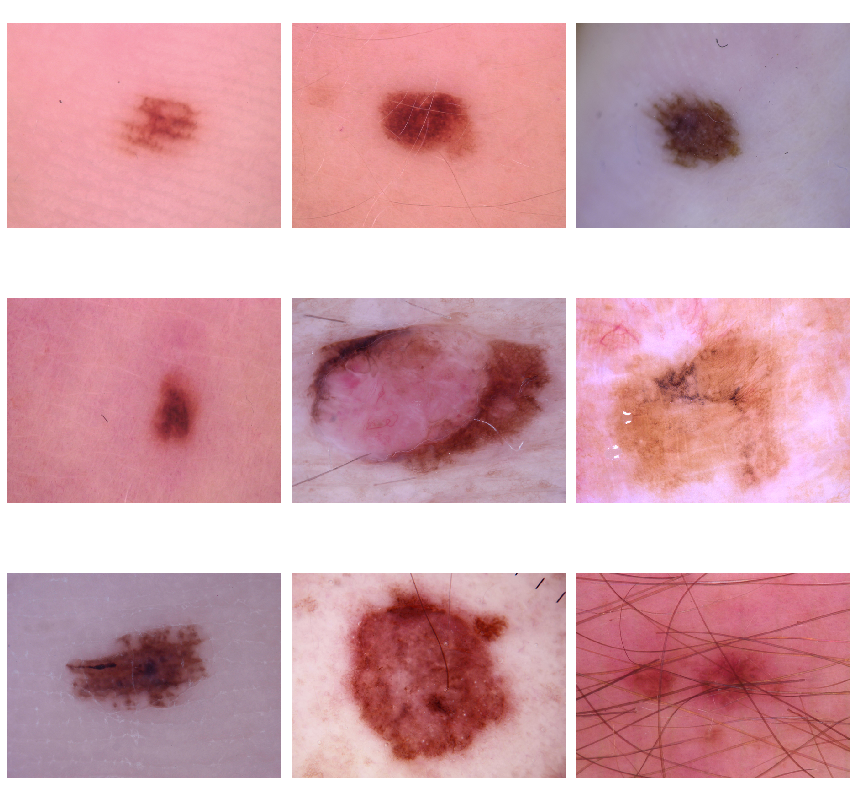

In [12]:
data.show_batch(rows=3)

In [13]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'], 7, 8012, 2003)

In [32]:
learn1 = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy, dice], model_dir=model_dir)
learn1.model = torch.nn.DataParallel(learn1.model)

# 29	0.005424	0.552628	0.099351	02:46

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/dsw/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:03<00:00, 27.7MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


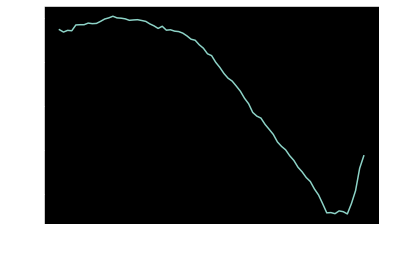

In [33]:
learn1.lr_find()
learn1.recorder.plot()

In [34]:
lr = 1e-02
learn1.fit_one_cycle(13, slice(lr), callbacks=[SaveModelCallback(learn1, name='best_resnet34')])

Better model found at epoch 0 with valid_loss value: 0.8368992209434509.
Better model found at epoch 1 with valid_loss value: 0.7129546999931335.
Better model found at epoch 2 with valid_loss value: 0.5903834104537964.
Better model found at epoch 4 with valid_loss value: 0.5442569851875305.
Better model found at epoch 6 with valid_loss value: 0.4790850281715393.
Better model found at epoch 8 with valid_loss value: 0.4695817232131958.


In [36]:
type(learn1)

fastai.basic_train.Learner

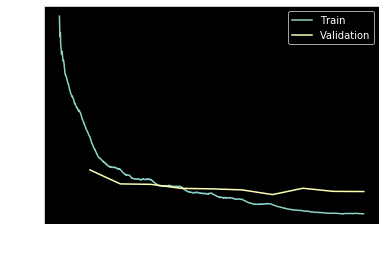

In [17]:
learn1.recorder.plot_losses()

In [37]:
import torch
import torch.nn as nn
import numpy as np
from onnx_coreml import convert
from torch.autograd import Variable
import torch.onnx
import torchvision
import onnx

W1118 11:51:07.295437 140018682521408 __init__.py:72] TensorFlow version 2.0.0 detected. Last version known to be fully compatible is 1.14.0 .


In [46]:
dummy_input = Variable(torch.rand(1,3,224,224, device='cpu'))
#torch.onnx.export(learn1.model, dummy_input, model_name, input_names=['image'], output_names=['diagnosis'], verbose=False)
torch.onnx.export(learn1.model.module, dummy_input, model_name, input_names=['image'], output_names=['diagnosis'], verbose=False)


In [49]:
mlmodel =convert(onnx.load(model_name), image_input_names=['image'], mode='classifier', class_labels=data.classes)
mlmodel.author = 'jld'
mlmodel.license = 'Apachev2'
mlmodel.short_description = 'detect cancer in mole picture'
mlmodel.output_description['diagnosis'] = 'Confidence and label of mole'
mlmodel.output_description['classLabel'] = 'Label of mole prediction'
mlmodel.save(f'{model_name}.mlmodel')

1/135: Converting Node Type Conv
2/135: Converting Node Type BatchNormalization
3/135: Converting Node Type Relu
4/135: Converting Node Type MaxPool
5/135: Converting Node Type Conv
6/135: Converting Node Type BatchNormalization
7/135: Converting Node Type Relu
8/135: Converting Node Type Conv
9/135: Converting Node Type BatchNormalization
10/135: Converting Node Type Add
11/135: Converting Node Type Relu
12/135: Converting Node Type Conv
13/135: Converting Node Type BatchNormalization
14/135: Converting Node Type Relu
15/135: Converting Node Type Conv
16/135: Converting Node Type BatchNormalization
17/135: Converting Node Type Add
18/135: Converting Node Type Relu
19/135: Converting Node Type Conv
20/135: Converting Node Type BatchNormalization
21/135: Converting Node Type Relu
22/135: Converting Node Type Conv
23/135: Converting Node Type BatchNormalization
24/135: Converting Node Type Add
25/135: Converting Node Type Relu
26/135: Converting Node Type Conv
27/135: Converting Node Typ

In [51]:
import coremltools

model =  coremltools.models.MLModel(f'{model_name}.mlmodel')

In [53]:
model.visualize_spec

<bound method MLModel.visualize_spec of input {
  name: "image"
  type {
    imageType {
      width: 224
      height: 224
      colorSpace: RGB
    }
  }
}
output {
  name: "diagnosis"
  shortDescription: "Confidence and label of mole"
  type {
    dictionaryType {
      stringKeyType {
      }
    }
  }
}
output {
  name: "classLabel"
  shortDescription: "Label of mole prediction"
  type {
    stringType {
    }
  }
}
predictedFeatureName: "classLabel"
predictedProbabilitiesName: "diagnosis"
metadata {
  shortDescription: "detect cancer in mole picture"
  author: "jld"
  license: "Apachev2"
}
>

In [18]:
preds,y,losses = learn1.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn1, preds, y, losses)
interp.confusion_matrix()

array([[  53,    7,    4,    0,    6,    1,    0],
       [   8,   79,    1,    1,    4,    4,    2],
       [   6,    4,  182,    3,   13,   25,    0],
       [   2,    0,    0,   12,    0,    6,    0],
       [   2,    3,   11,    0,  141,   71,    1],
       [   4,    5,    7,    1,   14, 1281,    0],
       [   0,    0,    0,    0,    0,    2,   37]])

array([[  53,    6,    6,    2,    2,    2,    0],
       [   3,   79,    3,    1,    4,    9,    0],
       [   3,    5,  180,    0,   10,   35,    0],
       [   0,    1,    0,   15,    0,    4,    0],
       [   1,    1,   11,    0,  149,   67,    0],
       [   2,    4,    8,    0,   16, 1282,    0],
       [   1,    0,    1,    1,    0,    5,   31]])

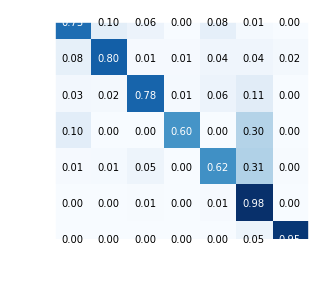

In [19]:
interp.plot_confusion_matrix(normalize=True)

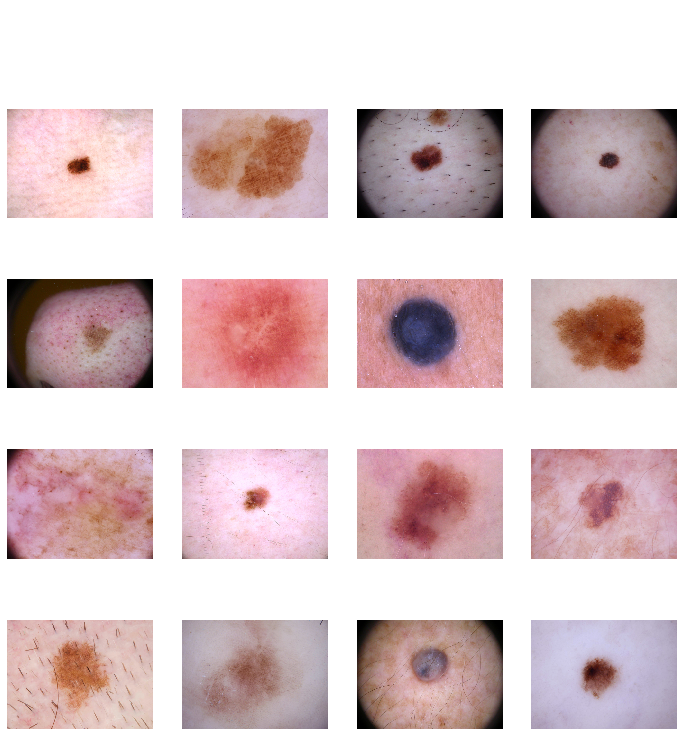

In [20]:
interp.plot_top_losses(16, figsize=(12,12))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


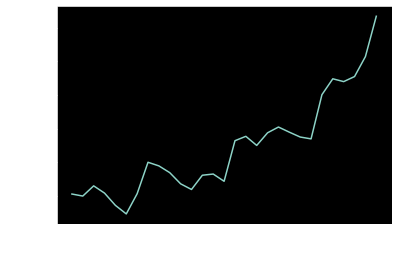

In [21]:
learn1.unfreeze()
learn1.lr_find()
learn1.recorder.plot()

In [31]:
learn2 = cnn_learner(data, models.vgg19_bn, metrics=[error_rate, accuracy, dice], model_dir=model_dir)
learn2.model = torch.nn.DataParallel(learn2.model)

RuntimeError: CUDA error: an illegal memory access was encountered

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


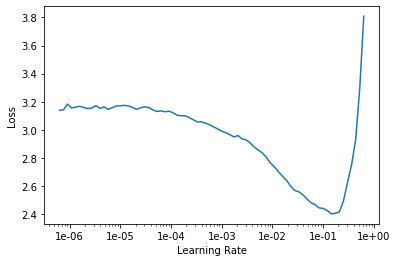

In [22]:
learn2.lr_find()
learn2.recorder.plot()

In [23]:
lr = 1e-02
learn2.fit_one_cycle(10, slice(lr))

RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/home/dsw/miniconda3/lib/python3.7/site-packages/torch/nn/parallel/parallel_apply.py", line 60, in _worker
    output = module(*input, **kwargs)
  File "/home/dsw/miniconda3/lib/python3.7/site-packages/torch/nn/modules/module.py", line 547, in __call__
    result = self.forward(*input, **kwargs)
  File "/home/dsw/miniconda3/lib/python3.7/site-packages/torch/nn/modules/container.py", line 92, in forward
    input = module(input)
  File "/home/dsw/miniconda3/lib/python3.7/site-packages/torch/nn/modules/module.py", line 547, in __call__
    result = self.forward(*input, **kwargs)
  File "/home/dsw/miniconda3/lib/python3.7/site-packages/torch/nn/modules/container.py", line 92, in forward
    input = module(input)
  File "/home/dsw/miniconda3/lib/python3.7/site-packages/torch/nn/modules/module.py", line 547, in __call__
    result = self.forward(*input, **kwargs)
  File "/home/dsw/miniconda3/lib/python3.7/site-packages/torch/nn/modules/container.py", line 92, in forward
    input = module(input)
  File "/home/dsw/miniconda3/lib/python3.7/site-packages/torch/nn/modules/module.py", line 547, in __call__
    result = self.forward(*input, **kwargs)
  File "/home/dsw/miniconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py", line 343, in forward
    return self.conv2d_forward(input, self.weight)
  File "/home/dsw/miniconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py", line 340, in conv2d_forward
    self.padding, self.dilation, self.groups)
RuntimeError: cuDNN error: CUDNN_STATUS_INTERNAL_ERROR


In [ ]:
learn2.recorder.plot_losses()

In [ ]:
learn2.unfreeze()
learn2.lr_find()
learn2.recorder.plot()

In [ ]:
interp.plot_top_losses(16, figsize=(12,12))

In [14]:
learn3 = cnn_learner(data, models.densenet201, metrics=[error_rate, accuracy, dice], model_dir=model_dir)
learn3.model = torch.nn.DataParallel(learn3.model)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


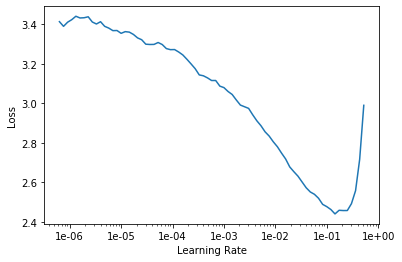

In [15]:
learn3.lr_find()
learn3.recorder.plot()

In [16]:
lr = 1e-02
learn3.fit_one_cycle(10, slice(lr))

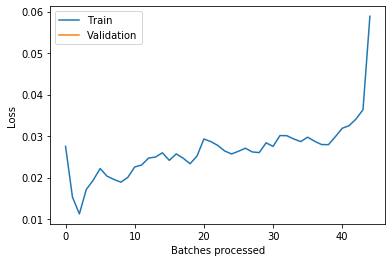

In [23]:
learn3.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


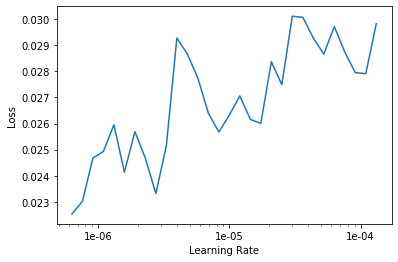

In [18]:
learn3.unfreeze()
learn3.lr_find()
learn3.recorder.plot()

In [20]:
preds,y,losses = learn3.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn3, preds, y, losses)
interp.confusion_matrix()

array([[  55,    3,    5,    2,    6,    0,    0],
       [   6,   78,    3,    1,    2,    9,    0],
       [   2,    5,  184,    1,   22,   18,    1],
       [   1,    1,    1,   13,    0,    4,    0],
       [   1,    0,   16,    0,  159,   52,    1],
       [   2,    3,    7,    0,   36, 1264,    0],
       [   0,    0,    1,    0,    2,    2,   34]])

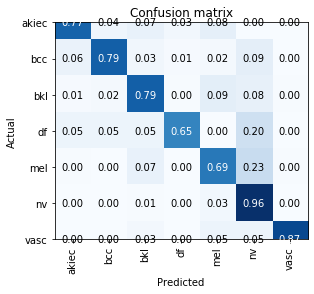

In [27]:
interp.plot_confusion_matrix(normalize=True)